In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import pandas as pd

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial.distance import correlation
from scipy.stats import wasserstein_distance, norm
from tslearn.metrics import dtw
import numpy as np

plt.style.use(["seaborn-paper"])


/home/wcx/GD_project/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wcx/GD_project/venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/tmp/ipykernel_1155003/1885264880.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-paper"])


In [ ]:
def autocor(data, lags, plot=False):
    # compute autocorrelation for lag=[0:lags]
    cor = sm.tsa.acf(data, nlags=lags)
    if plot:
        sm.graphics.tsa.plot_acf(data, lags=lags)
        plt.show()
    return cor


def cdf(data):
    # return CDF function
    return ECDF(data)


def psd(data):
    # compute power spectral density
    pxx, freqs = plt.psd(data)
    return pxx, freqs


def cor_dist(data_1, data_2):
    # compute correlation distance between data_1 & data_2
    return correlation(data_1, data_2)


def ws_dist(data_1, data_2):
    # compute wasserstein distance between the distribution data_1 & data_2
    distrib_1 = norm.pdf(data_1)
    distrib_2 = norm.pdf(data_2)
    return wasserstein_distance(distrib_1, distrib_2)


def dtw_dist(data_1, data_2):
    # compute distance between data_1 & data_2 by Dynamic time warping
    return dtw(data_1, data_2)

0. Distribution Shift

In [ ]:
tp = "pv"
ks = [2, 5, 10]
c = 0.75

real = torch.load(f'real_{tp}.pt').cpu()
n = len(real)
sums_real = torch.trapezoid(real, dx=1 / 4).cpu().numpy() / 10
fig, axs = plt.subplots()
sns.histplot(sums_real.flatten(),
             ax=axs,
             label="k = 0",
             kde=True,
             stat="density")
for i in range(len(ks)):
    k = ks[i]
    val = int((c**k) * n)
    X_s = torch.load(f'DistShift_{tp}/fake{k}.pt').cpu()
    X_concat = torch.cat([real[:val], X_s[:n - val]], 0)
    sums_shift = torch.trapezoid(X_concat, dx=1 / 4).cpu().numpy() / 10
    sns.histplot(
        sums_shift.flatten(),
        ax=axs,
        label=f"k = {k}",
        kde=True,
        stat="density")
    axs.legend()
    axs.set(xlabel="Daily power generation (p.u.)")

fig.tight_layout()
fig.savefig(f"figs/{tp}_shift.png", dpi=350)

1. Reconstruct compare

In [ ]:
tp = "pv"
model = "ExGAN"
gen = torch.load(f"logs/{model}_{tp}_np.pt").squeeze()
real = torch.load(f"test_{tp}.pt").detach().cpu().numpy().squeeze()
fig, axs = plt.subplots(3, 4, figsize=[10, 7], sharey=True)
lag = 15
idxs = [2, 4, 13, 14]
for i in range(4):
    axs[0][i].plot(range(96), real[idxs[i]].squeeze(), label="Real", lw=2)
    axs[1][i].plot(range(96),
                   gen[idxs[i]].squeeze(),
                   label="Generated",
                   c="C1", lw=2)

    atc_tgt = autocor(real[idxs[i]], lags=lag)
    atc_best = autocor(gen[idxs[i]].squeeze(), lags=lag)
    axs[2][i].plot(range(len(atc_tgt)), atc_tgt, label="Real", lw=2)
    axs[2][i].plot(range(len(atc_tgt)), atc_best, label="Generated", lw=2)

    axs[0][i].set(ylim=[0, 1.1],
                  xlim=[0, 96],
                  ylabel="Power (p.u.)",
                  xlabel="Time (15min)")
    axs[1][i].set(ylim=[0, 1.1],
                  xlim=[0, 96],
                  ylabel="Power (p.u.)",
                  xlabel="Time (15min)")
    axs[2][i].set(ylim=[0, 1.1],
                  xlim=[0, lag],
                  ylabel="Autocorrelation Coefficient",
                  xlabel="Lag")
    axs[0][i].legend(loc=1)
    axs[1][i].legend(loc=1)
    axs[2][i].legend(loc=1)
    # axs[0][i].xaxis.set_major_locator(plt.MaxNLocator(3))
    # axs[1][i].yaxis.set_major_locator(plt.MaxNLocator(3))
    # axs[0][i].grid()
    # axs[1][i].grid()
    # axs[2][i].grid()

fig.tight_layout()
# fig.savefig(f"figs/{model}_{tp}_cor.png", dpi=350)

2. Single compare

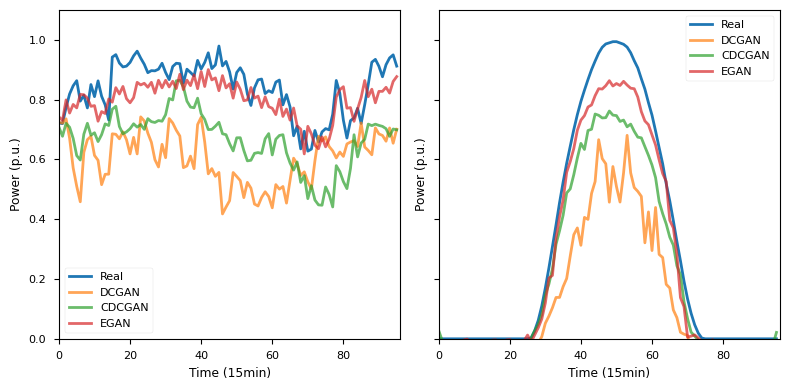

In [3]:
tp = ["wind", "pv"]
model = ["DCGAN", "CDCGAN", "ExGAN"]
names = ["DCGAN", "CDCGAN", "EGAN"]

fig, axs = plt.subplots(1, 2, figsize=[8, 4], sharey=True)
axs = axs.flatten()
# lag = 15
idxs = 2
for i in range(len(tp)):
    real = torch.load(f"test_{tp[i]}.pt").detach().cpu().numpy().squeeze()
    axs[i].plot(range(96), real[idxs], label="Real", lw=2)
    for j in range(len(model)):
        gen = torch.load(f"logs/{model[j]}_{tp[i]}_np.pt").squeeze()
        axs[i].plot(range(96), gen[idxs], label=names[j], lw=2, alpha=0.7)
    axs[i].set(ylim=[0, 1.1],
                  xlim=[0, 96],
                  ylabel="Power (p.u.)",
                  xlabel="Time (15min)")
    # axs[i].grid()
    axs[i].legend()
fig.tight_layout()
fig.savefig(f"figs/model_compare.png", dpi=350)


2. Stats

In [ ]:
tp = "wind"
model = ["ExGAN"]
# model = ["DCGAN", "CDCGAN", "ExGAN"]
if tp == "pv" and model == "ExGAN":
    num = 730
else:
    num = 3288

if not model == "ExGAN":
    num = "np"

fig, axs = plt.subplots(2, 1)
# fig, axs = plt.subplots(2, 1, figsize=[10, 7])
axs = axs.flatten()

real = torch.load(f"test_{tp}.pt").detach().cpu().numpy().squeeze()
real = np.delete(real, slice(81, 110), 0)
real = real.flatten()[:150 * 96]

x = np.linspace(0, 1)
fn_target = ECDF(real)
axs[0].step(x, fn_target(x), label="Real", lw=2)
sns.histplot(real.flatten(), ax=axs[1], label="Real", kde=True, stat="density")
for i in range(len(model)):
    gen = torch.load(f"logs/{model[i]}_{tp}_{num}.pt").squeeze()
    gen = np.maximum(gen, 0)
    gen = np.delete(gen, slice(81, 110), 0)
    gen = gen.flatten()[:150 * 96]

    fn_fit = ECDF(gen)

    axs[0].step(x, fn_fit(x), label=model[i], lw=2)
    # axs[0].step(x, fn_fit(x), label="Generated", lw=2)
    axs[0].set(ylabel="CDF")
    sns.histplot(gen.flatten(),
                ax=axs[1],
                label=model[i],
                # label="Generated",
                kde=True,
                stat="density")

    axs[0].legend()
    axs[1].legend()

fig.tight_layout()
fig.savefig(f"figs/{tp}_stats.png", dpi=350)

3. Spatial

/tmp/ipykernel_1155003/1856620544.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set(xticklabels=range(0, 26, 5),


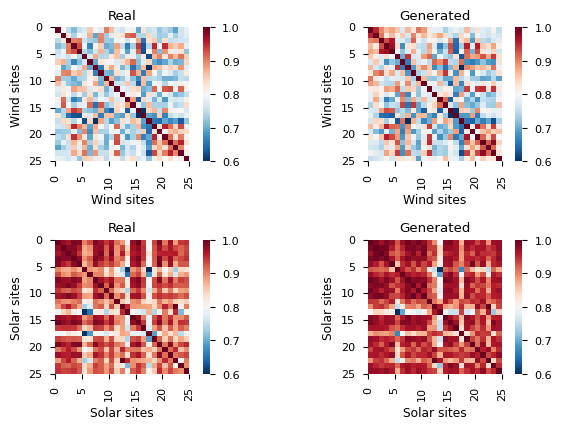

In [6]:
tps = ["wind", "pv"]
model = "ExGAN"
if tp == "pv" and model == "ExGAN":
    num = 730
else:
    num = 3288

if not model == "DCGAN":
    num = "np"

fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
for i in range(4):
    tp = "pv" if i / 2 >= 1 else "wind"

    real = torch.load(f"test_{tp}.pt").detach().cpu().numpy().squeeze()
    real = np.delete(real, slice(81, 110), 0)

    gen = torch.load(f"logs/{model}_{tp}_{num}.pt").squeeze()
    gen = np.maximum(gen, 0)
    gen = np.delete(gen, slice(81, 110), 0)

    num_site = 25
    idxs = slice(0, num_site)
    real, gen = real[idxs], gen[idxs]

    heat_map = np.zeros([num_site, num_site])
    temp = real if i % 2 == 0 else gen
    for j in range(num_site):
        for k in range(num_site):
            coef = np.corrcoef(temp[j], temp[k])[0, 1]
            # coef = min(abs(coef) + 0.1, 1)
            heat_map[j, k] = coef
    heat_map = (heat_map - heat_map.min()) / (heat_map.max() -
                                              heat_map.min()) * (1 - 0.6) + 0.6

    sns.heatmap(heat_map,
                ax=axs[i],
                cmap="RdBu_r",
                vmax=1,
                vmin=0.6,
                square=True)
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axs[i].set(xticklabels=range(0, 26, 5),
               yticklabels=range(0, 26, 5),
               xlabel="Wind sites" if int(i / 2) == 0 else "Solar sites",
               ylabel="Wind sites" if int(i / 2) == 0 else "Solar sites",
               title="Real" if i % 2 == 0 else "Generated")
fig.tight_layout()
fig.savefig(f"figs/spatial.png", dpi=350)


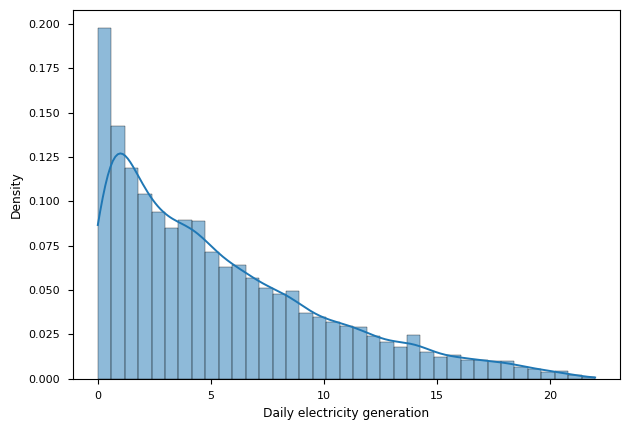

In [73]:
# np.random.seed(1)
real = torch.load("real_wind.pt").detach().cpu().numpy().squeeze()
ext = np.trapz(real, dx=1 / 4).flatten()
fig, ax = plt.subplots()
sns.histplot(ext, kde=True, stat="density", ax=ax)
ax.set(xlabel="Daily electricity generation")
fig.tight_layout()
fig.savefig("figs/intro.png", dpi=350)
